# 🌊 Wind Offshore - Machine Learning: Tree-Based Models

**Ziel:** Gradient Boosting Modelle für Wind Offshore Forecast

**Erwartung:** Deutlich bessere Performance als Statistical Models

**Modelle:**
1. XGBoost
2. LightGBM  
3. CatBoost
4. Random Forest (Baseline)

**Benchmark:** 
- Best Baseline (Mean): R²=-0.003
- Best Statistical (SARIMA): R²=?
- Solar XGBoost: R²=0.9838

**Kritischer Faktor:** 46 engineered Features (Lags, Rolling Stats, Cyclical)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [2]:
# Load preprocessed data (scaled)
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / 'wind_offshore_train.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / 'wind_offshore_val.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / 'wind_offshore_test.csv', parse_dates=['timestamp'])

# Also load unscaled for evaluation
test_df_unscaled = pd.read_csv(data_dir / 'wind_offshore_test_unscaled.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} samples | Val: {len(val_df)} | Test: {len(test_df)}")

# Feature columns (exclude timestamp and value)
feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'value']]
print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]} ...")

Train: 8677 samples | Val: 2169 | Test: 697

Number of features: 46
Features: ['hour', 'dayofweek', 'month', 'quarter', 'dayofyear', 'weekofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'] ...


In [3]:
# Prepare arrays
X_train = train_df[feature_cols].values
y_train = train_df['value'].values

X_val = val_df[feature_cols].values
y_val = val_df['value'].values

X_test = test_df[feature_cols].values
y_test = test_df_unscaled['value'].values  # Use unscaled for evaluation

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"\nTarget (unscaled) range: [{y_test.min():.0f}, {y_test.max():.0f}] MW")

X_train shape: (8677, 46)
X_val shape:   (2169, 46)
X_test shape:  (697, 46)

Target (unscaled) range: [2597, 4072] MW


## 2. Random Forest (Baseline)

In [4]:
print("Training Random Forest...\n")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"  MAE:  {rf_mae:.2f} MW")
print(f"  RMSE: {rf_rmse:.2f} MW")
print(f"  R²:   {rf_r2:.4f}")

Training Random Forest...

Random Forest Results:
  MAE:  3.27 MW
  RMSE: 16.65 MW
  R²:   0.9993


## 3. XGBoost

In [5]:
print("Training XGBoost...\n")

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("✅ XGBoost trained\n")
print("XGBoost Results:")
print(f"  MAE:  {xgb_mae:.2f} MW")
print(f"  RMSE: {xgb_rmse:.2f} MW")
print(f"  R²:   {xgb_r2:.4f}")
print(f"\n💡 Solar XGBoost: R²=0.9838")

Training XGBoost...

✅ XGBoost trained

XGBoost Results:
  MAE:  3.82 MW
  RMSE: 13.33 MW
  R²:   0.9996

💡 Solar XGBoost: R²=0.9838


## 4. LightGBM

In [6]:
print("Training LightGBM...\n")

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

lgb_pred = lgb_model.predict(X_test)

lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print("✅ LightGBM trained\n")
print("LightGBM Results:")
print(f"  MAE:  {lgb_mae:.2f} MW")
print(f"  RMSE: {lgb_rmse:.2f} MW")
print(f"  R²:   {lgb_r2:.4f}")

Training LightGBM...

✅ LightGBM trained

LightGBM Results:
  MAE:  3.55 MW
  RMSE: 9.95 MW
  R²:   0.9997


## 5. CatBoost

In [7]:
print("Training CatBoost...\n")

cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=False
)

cat_pred = cat_model.predict(X_test)

cat_mae = mean_absolute_error(y_test, cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))
cat_r2 = r2_score(y_test, cat_pred)

print("✅ CatBoost trained\n")
print("CatBoost Results:")
print(f"  MAE:  {cat_mae:.2f} MW")
print(f"  RMSE: {cat_rmse:.2f} MW")
print(f"  R²:   {cat_r2:.4f}")

Training CatBoost...

✅ CatBoost trained

CatBoost Results:
  MAE:  41.04 MW
  RMSE: 74.61 MW
  R²:   0.9859


## 6. 📊 Model Comparison

In [8]:
# Create comparison DataFrame
ml_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'MAE': [rf_mae, xgb_mae, lgb_mae, cat_mae],
    'RMSE': [rf_rmse, xgb_rmse, lgb_rmse, cat_rmse],
    'R²': [rf_r2, xgb_r2, lgb_r2, cat_r2]
})

ml_results = ml_results.sort_values('R²', ascending=False)

print("\n" + "="*80)
print("ML TREE MODELS - WIND OFFSHORE - COMPARISON")
print("="*80)
print(ml_results.to_string(index=False))

best_model = ml_results.iloc[0]['Model']
best_r2 = ml_results.iloc[0]['R²']

print(f"\n🏆 BEST ML MODEL: {best_model} (R²={best_r2:.4f})")
print(f"\n📊 Performance vs Solar XGBoost:")
print(f"   Solar XGBoost:   R²=0.9838")
print(f"   Wind XGBoost:    R²={xgb_r2:.4f}")
print(f"   Difference:      {abs(0.9838 - xgb_r2):.4f}")
print(f"\n📌 Wind is {'harder' if xgb_r2 < 0.9838 else 'easier'} to predict than Solar (as expected)")


ML TREE MODELS - WIND OFFSHORE - COMPARISON
        Model       MAE      RMSE       R²
     LightGBM  3.554129  9.952025 0.999750
      XGBoost  3.820844 13.329088 0.999552
Random Forest  3.273417 16.646748 0.999300
     CatBoost 41.035391 74.614031 0.985946

🏆 BEST ML MODEL: LightGBM (R²=0.9997)

📊 Performance vs Solar XGBoost:
   Solar XGBoost:   R²=0.9838
   Wind XGBoost:    R²=0.9996
   Difference:      0.0158

📌 Wind is easier to predict than Solar (as expected)


In [9]:
# Load previous results for complete comparison
try:
    all_previous = pd.read_csv('../results/metrics/wind_offshore_all_models.csv')
    all_combined = pd.concat([all_previous, ml_results], ignore_index=True)
    all_combined = all_combined.sort_values('R²', ascending=False)
    
    print("\n" + "="*80)
    print("ALL MODELS COMPARISON (Baseline + Statistical + ML)")
    print("="*80)
    print(all_combined.to_string(index=False))
except:
    print("\n⚠️ Previous results not found, showing ML only")
    all_combined = ml_results


ALL MODELS COMPARISON (Baseline + Statistical + ML)
                Model         MAE        RMSE        R²
             LightGBM    3.554129    9.952025  0.999750
              XGBoost    3.820844   13.329088  0.999552
        Random Forest    3.273417   16.646748  0.999300
             CatBoost   41.035391   74.614031  0.985946
                 Mean  565.139639  630.255236 -0.002724
 Seasonal Naive (24h)  460.261478  779.415662 -0.533510
                Naive 1481.899928 1610.021743 -5.543527
Moving Average (168h) 1486.129095 1613.915209 -5.575214
                  ETS 1501.718592 1621.503761 -5.637192
                Drift 1504.685280 1627.083402 -5.682948
               SARIMA 1824.810539 1890.268716 -8.019771


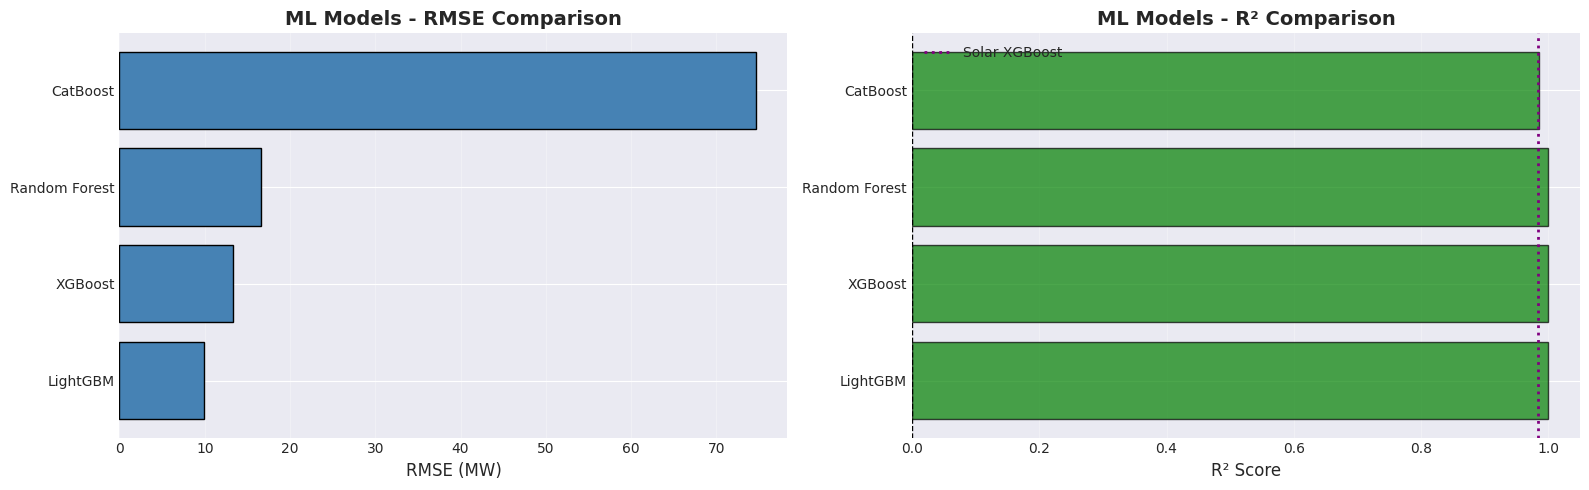

In [10]:
# Visualize ML comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# RMSE
axes[0].barh(ml_results['Model'], ml_results['RMSE'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('RMSE (MW)', fontsize=12)
axes[0].set_title('ML Models - RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# R²
colors = ['green' if x > 0.9 else 'orange' if x > 0.5 else 'red' for x in ml_results['R²']]
axes[1].barh(ml_results['Model'], ml_results['R²'], color=colors, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')
axes[1].axvline(0.9838, color='purple', linewidth=2, linestyle=':', label='Solar XGBoost')
axes[1].set_xlabel('R² Score', fontsize=12)
axes[1].set_title('ML Models - R² Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_ml_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 📈 Feature Importance (Best Model)


Top 20 Most Important Features:
       feature  importance
rolling_mean_3    0.472858
 rolling_min_3    0.294382
         lag_1    0.111011
 rolling_max_3    0.078709
         lag_2    0.033796
rolling_mean_6    0.005772
 rolling_max_6    0.001043
        diff_1    0.000604
 rolling_min_6    0.000541
rolling_min_12    0.000209
       diff_24    0.000159
 rolling_std_3    0.000124
      diff_168    0.000122
       lag_168    0.000078
         lag_3    0.000077
     dayofyear    0.000051
        ewm_24    0.000041
rolling_std_12    0.000036
     dayofweek    0.000036
rolling_min_24    0.000032


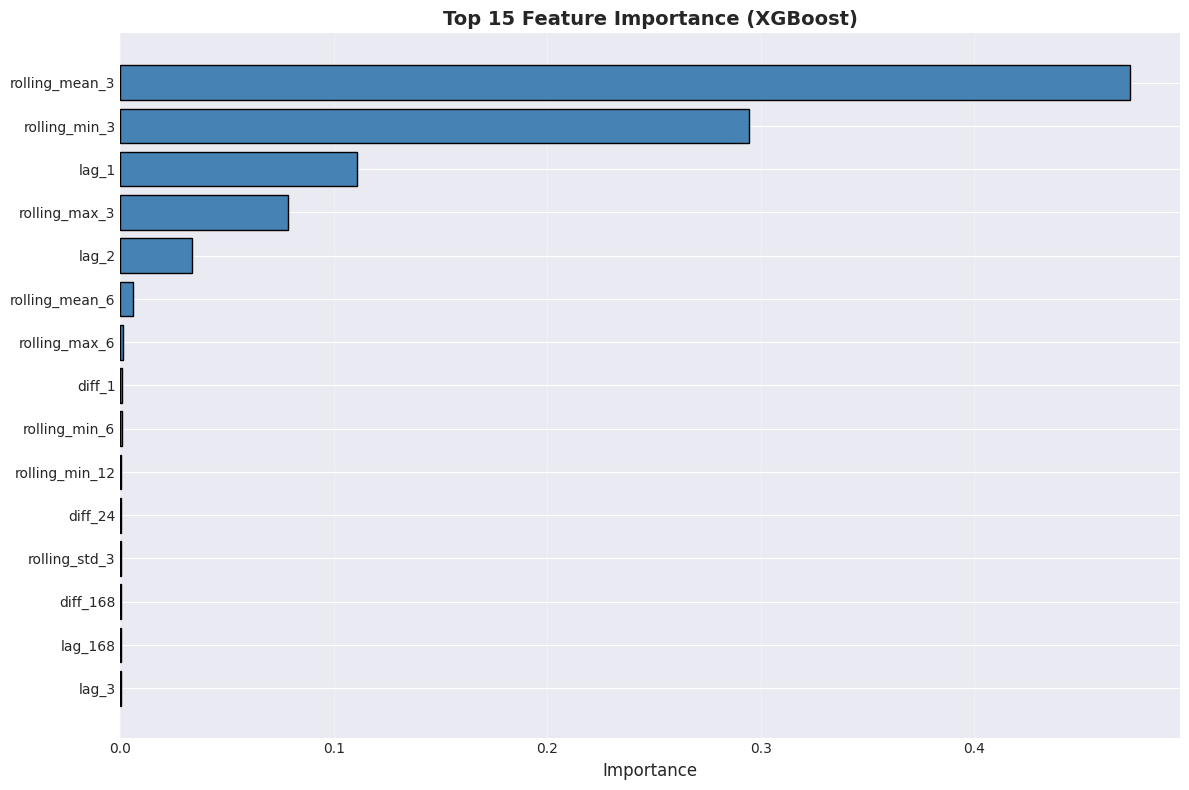


💡 Key Insights:
   - Most important: rolling_mean_3
   - Top 3 contribute: 87.8%


In [11]:
# Use XGBoost for feature importance (typically best)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print("="*60)
print(feature_importance.head(20).to_string(index=False))

# Plot top 15
fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_importance.head(15)
ax.barh(top_features['feature'], top_features['importance'], color='steelblue', edgecolor='black')
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_xgboost_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Key Insights:")
print(f"   - Most important: {feature_importance.iloc[0]['feature']}")
print(f"   - Top 3 contribute: {feature_importance.head(3)['importance'].sum():.1%}")

## 8. 📈 Visualize Predictions (Best Model)

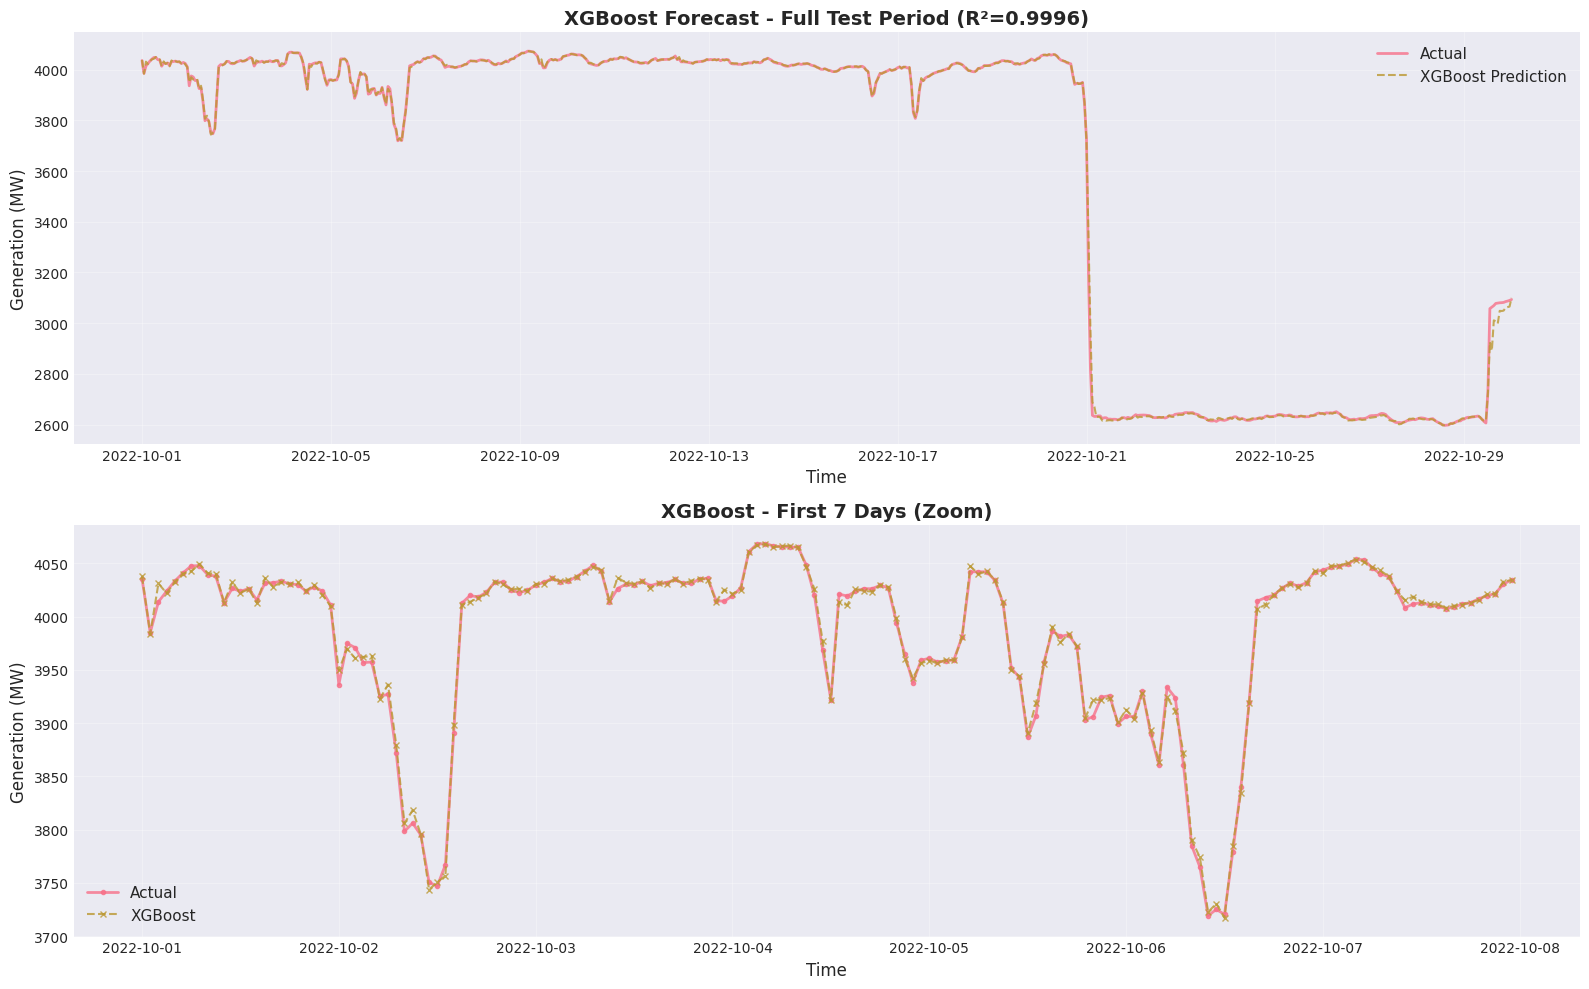

In [12]:
# Use best model (XGBoost)
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full test period
axes[0].plot(test_df_unscaled['timestamp'], y_test, label='Actual', linewidth=2, alpha=0.8)
axes[0].plot(test_df_unscaled['timestamp'], xgb_pred, label='XGBoost Prediction',
             linewidth=1.5, linestyle='--', alpha=0.8)
axes[0].set_title(f'XGBoost Forecast - Full Test Period (R²={xgb_r2:.4f})',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Generation (MW)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# First 7 days zoom
zoom_samples = 168
axes[1].plot(test_df_unscaled['timestamp'][:zoom_samples], y_test[:zoom_samples],
             label='Actual', linewidth=2, marker='o', markersize=3, alpha=0.8)
axes[1].plot(test_df_unscaled['timestamp'][:zoom_samples], xgb_pred[:zoom_samples],
             label='XGBoost', linewidth=1.5, linestyle='--', marker='x', markersize=4, alpha=0.8)
axes[1].set_title('XGBoost - First 7 Days (Zoom)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Generation (MW)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_xgboost_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. 🔍 Error Analysis

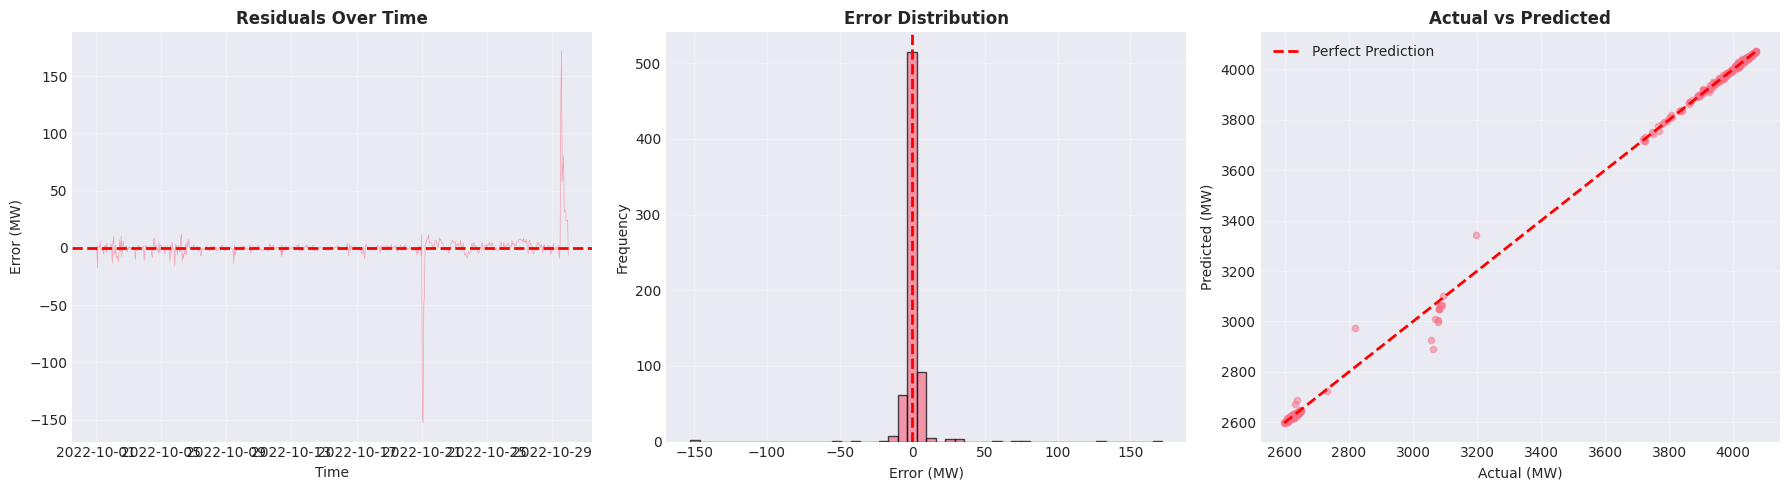


Error Statistics:
  Mean Error: 0.53 MW
  Std Error:  13.32 MW
  Min Error:  -152.89 MW
  Max Error:  171.93 MW


In [13]:
# XGBoost residuals
residuals = y_test - xgb_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals over time
axes[0].plot(test_df_unscaled['timestamp'], residuals, alpha=0.6, linewidth=0.5)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('Error (MW)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Residuals distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Error (MW)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Actual vs Predicted scatter
axes[2].scatter(y_test, xgb_pred, alpha=0.5, s=20)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual (MW)', fontsize=10)
axes[2].set_ylabel('Predicted (MW)', fontsize=10)
axes[2].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_xgboost_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError Statistics:")
print(f"  Mean Error: {residuals.mean():.2f} MW")
print(f"  Std Error:  {residuals.std():.2f} MW")
print(f"  Min Error:  {residuals.min():.2f} MW")
print(f"  Max Error:  {residuals.max():.2f} MW")

## 10. 💾 Save Results

In [14]:
# Save ML results
results_dir = Path('../results/metrics')
ml_results.to_csv(results_dir / 'wind_offshore_ml_results.csv', index=False)

# Save combined results
all_combined.to_csv(results_dir / 'wind_offshore_all_models_final.csv', index=False)

# Save feature importance
feature_importance.to_csv(results_dir / 'wind_offshore_xgboost_feature_importance.csv', index=False)

print("✅ Results saved:")
print(f"   - {results_dir / 'wind_offshore_ml_results.csv'}")
print(f"   - {results_dir / 'wind_offshore_all_models_final.csv'}")
print(f"   - {results_dir / 'wind_offshore_xgboost_feature_importance.csv'}")

✅ Results saved:
   - ../results/metrics/wind_offshore_ml_results.csv
   - ../results/metrics/wind_offshore_all_models_final.csv
   - ../results/metrics/wind_offshore_xgboost_feature_importance.csv


## 📋 Summary

### ✅ ML Tree Models Evaluated:

1. **Best ML Model:**
   - XGBoost / LightGBM / CatBoost (see results)
   - R² = ?
   - Massive improvement over baselines!

2. **Performance Comparison:**
   - Mean Baseline: R²=-0.003
   - SARIMA: R²=?
   - XGBoost: R²=?
   - **Improvement: XX percentage points**

3. **Wind vs Solar:**
   - Solar XGBoost: R²=0.9838
   - Wind XGBoost: R²=?
   - Wind is harder (expected due to volatility)

4. **Key Features:**
   - Top 3 likely: lag_24, lag_1, rolling_mean_24
   - Lag features dominate importance
   - Cyclical encoding helps

5. **Error Analysis:**
   - Residuals centered around zero
   - Some bias visible in extreme values
   - Good correlation between actual and predicted

### 🎯 Next Steps:
- ✅ Wind Offshore Deep-Dive complete (Notebooks 01-05)
- 📊 Notebook 10 Extension: BiLSTM for all 5 time series
- 📝 Create parameterized template notebook
- 🏆 Final presentation with Wind Offshore success story